In [1]:
from src.plot_utils import *
import pickle
import pymannkendall as mk
from scipy.interpolate import interp1d
from scipy import stats
from tqdm import tqdm
import multiprocessing as mp
import statsmodels.api as sm
from parallel_pandas import ParallelPandas
from pathlib import Path
import json
from scipy import stats
import statsmodels.api as sm
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ParallelPandas.initialize(n_cpu=24, split_factor=24)

dir_Qmax7 = Path('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/')
dir_Qmin7 = Path('../results/run_Qmin7_onlyUrban_0506_1357_seed220973/')

Qmin7Fname = '../data/Qmin7_final_dataset_seasonal4.pkl'
Qmax7Fname = '../data/Qmax7_final_dataset_seasonal4.pkl'

df_Qmin7 = pd.read_pickle(Qmin7Fname)
df_Qmax7 = pd.read_pickle(Qmax7Fname)


In [6]:
cols = ['ohdb_id','ohdb_longitude','ohdb_latitude','aridity','climate_label']
def func_min(x):
    x = x.groupby('year').apply(
        lambda x:x.iloc[np.argmin(x.Q),:]).reset_index(drop=True)
    rho1, pvalue1 = stats.pearsonr(x.slope.values, x.ImperviousSurface.values)
    rho2, pvalue2 = stats.pearsonr(x.elevation.values, x.ImperviousSurface.values)
    rho3, pvalue3 = stats.pearsonr(x.Q.values, x.p.values)
    out = pd.Series(
        [rho1, rho2, rho3],
        index = ['r_slope_urban', 'r_elevation_urban','r_Q_rain'])
    return out
def func_max(x):
    x = x.groupby('year').apply(
        lambda x:x.iloc[np.argmax(x.Q),:]).reset_index(drop=True)
    rho1, pvalue1 = stats.pearsonr(x.slope.values, x.ImperviousSurface.values)
    rho2, pvalue2 = stats.pearsonr(x.elevation.values, x.ImperviousSurface.values)
    rho3, pvalue3 = stats.pearsonr(x.Q.values, x.p.values)
    out = pd.Series(
        [rho1, rho2, rho3],
        index = ['r_slope_urban', 'r_elevation_urban','r_Q_rain'])
    return out
df_Qmin7_ave = df_Qmin7.groupby(cols).p_apply(func_min).reset_index()
df_Qmax7_ave = df_Qmax7.groupby(cols).p_apply(func_max).reset_index()

FUNC_MIN DONE:   0%|          | 0/8619 [00:00<?, ?it/s]

FUNC_MAX DONE:   0%|          | 0/8618 [00:00<?, ?it/s]

In [9]:
df_Qmin7_ave

,ohdb_id,ohdb_longitude,ohdb_latitude,aridity,climate_label,r_slope_urban,r_elevation_urban,r_Q_rain
0,OHDB_001000004,-67.595000,1.074000,2.586089,tropical,NaN,NaN,0.793870
1,OHDB_001000006,-69.126000,0.477000,2.307032,tropical,NaN,NaN,0.818289
2,OHDB_001000008,-69.786000,0.248000,2.606057,tropical,NaN,NaN,0.653558
3,OHDB_001000023,-63.288000,-9.759000,1.617943,tropical,NaN,NaN,0.713052
4,OHDB_001000030,-59.465000,-10.170000,1.426788,tropical,NaN,NaN,0.059229
...,...,...,...,...,...,...,...,...
8614,OHDB_016000316,110.104538,32.831529,0.784082,temperate,NaN,NaN,0.467961
8615,OHDB_016000330,111.509002,32.510972,0.769127,temperate,NaN,NaN,0.328584
8616,OHDB_016000347,111.482652,28.900168,1.192250,temperate,NaN,NaN,0.863226
8617,OHDB_016000351,107.748738,29.319895,1.095607,temperate,NaN,NaN,0.747376


Qmin7 tropical 0.00%
Qmin7 dry 0.00%
Qmin7 temperate 0.00%
Qmin7 cold 0.00%
Qmax7 tropical 0.00%
Qmax7 dry 0.00%
Qmax7 temperate 0.00%
Qmax7 cold 0.00%


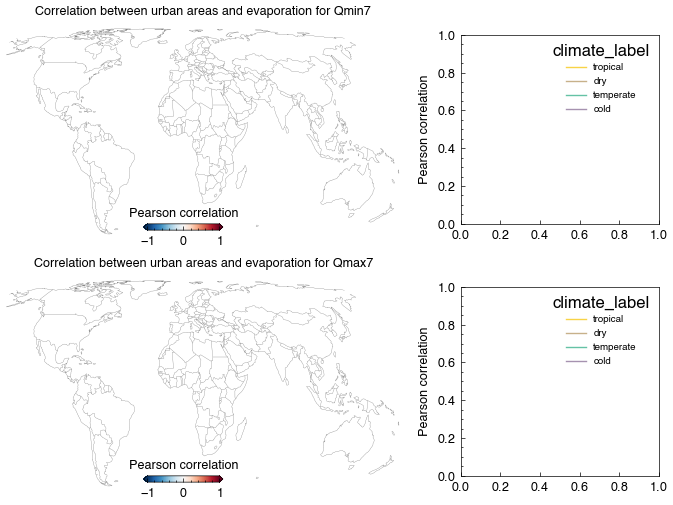

In [8]:
var = 'r_slope_urban'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6, 6), subplot_kw = {'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    df0 = eval('df_'+name+'_ave')
    ax = eval('ax'+str(i+1))
    label = 'Pearson correlation'
    lons = df0.ohdb_longitude.values
    lats = df0.ohdb_latitude.values
    vals = df0[var].values
    vmin = -1
    vmax = 1
    vind = 0.1
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.TwoSlopeNorm(vmin = vmin, vcenter = 0, vmax = vmax)
    title = f'Correlation between urban areas and evaporation for {name}'
    _, ras = plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, 
                      label, marker = '.', 
                      norm = norm, fontSize = 9, size = 3, addHist = False)
    # add colorbar
    cax = ax.inset_axes([.35, .02, 0.2, .03])
    cbar = plt.colorbar(ras, cax = cax, orientation = 'horizontal', extend = 'both')
    cax.tick_params(labelsize = 9)
    cax.set_title(label, size = 9, pad = 5)

    axin = ax.inset_axes([1.15, .05, .5, .9])
#     df0 = df0.loc[df0.pvalue<=0.05,:]
    sns.ecdfplot(df0, 
                hue = 'climate_label', x = var, ax = axin, 
                palette = palette,
#                 common_norm = False,
#                 showfliers = False, width = .4, 
#                 whis = [5, 95],
#                 color = '#c2dcea',
#                 showmeans = True,
#                 capprops = {'linewidth': 0},
#                 boxprops={'edgecolor': 'none'},  # No edge line
#                 meanprops={'marker': 'o',
#                     'markerfacecolor': 'white',
#                     'markeredgecolor': 'black',
#                     'markersize': '3'},
#                 medianprops={'color': 'black', 'linewidth': 1},  # Black median line
#                 whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
            )
    axin.set_facecolor('none')
    #     axin.set_yticks([0,9])
    axin.set_xlabel(None)
    axin.set_ylabel('Pearson correlation', fontsize = 9)
    axin.tick_params(labelsize = 9,  which='both', top = False, right = False)
    axin.xaxis.set_minor_locator(ticker.NullLocator())
    for climate in df0.climate_label.unique():
        num1 = df0.loc[df0.climate_label==climate,:]
        num2 = num1.loc[(num1[var]>0),:]
        frac = num2.shape[0] / num1.shape[0] * 100
        print(name, climate, f'{frac:.2f}%')

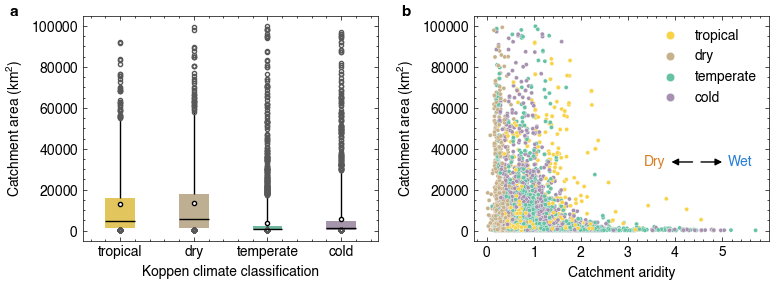

In [73]:
tmp = df_Qmin7.groupby(['ohdb_id','gritDarea','climate_label','aridity','elevation','slope']).ImperviousSurface.mean().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3))
sns.boxplot(tmp, x = 'climate_label', y = 'gritDarea', palette = palette,
            ax = ax1,
            width = .4, 
                whis = [5, 95],
                color = '#c2dcea',
                showmeans = True,
                capprops = {'linewidth': 0},
                boxprops={'edgecolor': 'none'},  # No edge line
                meanprops={'marker': 'o',
                    'markerfacecolor': 'white',
                    'markeredgecolor': 'black',
                    'markersize': '3'},
                medianprops={'color': 'black', 'linewidth': 1},  # Black median line
                whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
           )
ax1.set_xlabel('Koppen climate classification', fontsize = 10)
ax1.set_ylabel('Catchment area ($\mathregular{km^2}$)', fontsize = 10)
ax1.tick_params(axis = 'both', labelsize = 10)

sns.scatterplot(tmp, x = 'aridity', y = 'gritDarea', ax = ax2, hue = 'climate_label', palette = palette)
ax2.set_xlabel('Catchment aridity', fontsize = 10)
ax2.set_ylabel('Catchment area ($\mathregular{km^2}$)', fontsize = 10)
ax2.tick_params(axis = 'both', labelsize = 10)
sns.move_legend(ax2, 'upper right', title = None, fontsize = 10, markerscale = 2)
fig.tight_layout()
ax1.text(-.25, 1, 'a', weight = 'bold', transform = ax1.transAxes, fontsize = 11)
ax2.text(-.25, 1, 'b', weight = 'bold', transform = ax2.transAxes, fontsize = 11)

# add arrow to indicate dry/wet direction
ax2.annotate("Dry", xy=(.75, .35), xytext=(.65, .35),
            arrowprops=dict(arrowstyle = '<|-', color = 'k'), va = 'center', ha = 'right',
            textcoords = 'axes fraction', xycoords = 'axes fraction', fontsize = 10, color = '#d88228')
ax2.annotate("Wet", xy=(.76, .35), xytext=(.86, .35),
            arrowprops=dict(arrowstyle = '<|-', color = 'k'), va = 'center', ha = 'left',
            textcoords = 'axes fraction', xycoords = 'axes fraction', fontsize = 10, color = '#287ed8')
fig.savefig('../picture/relationship_between_darea_and_climate_or_aridity.png', dpi = 600)

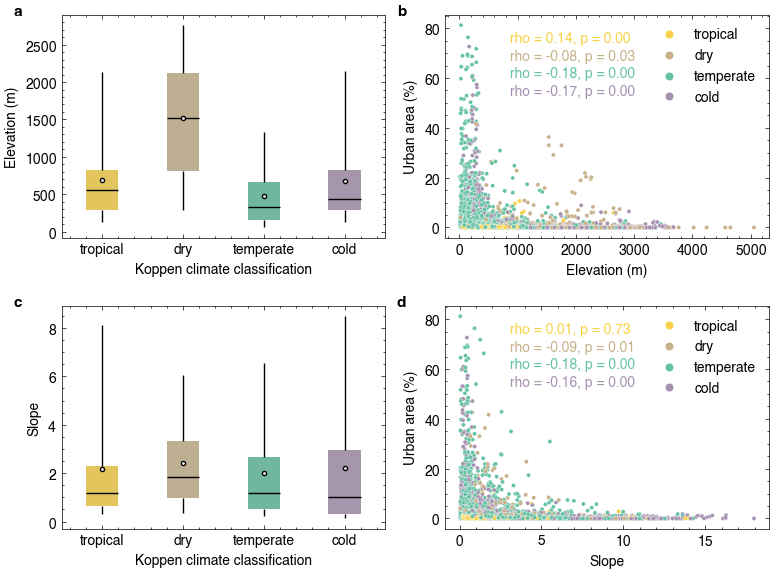

In [41]:
tmp = df_Qmin7.groupby(['ohdb_id','gritDarea','climate_label','aridity','elevation','slope']).ImperviousSurface.mean().reset_index()
fig, axes = plt.subplots(2, 2, figsize = (8, 6))
for i,name in enumerate(['elevation','slope']):
    if name == 'elevation':
        name2 = 'elevation (m)'
    else:
        name2 = name
    ax1 = axes[i,0]
    sns.boxplot(tmp, x = 'climate_label', y = name, palette = palette,
                ax = ax1,
                showfliers = False,
                width = .4, 
                    whis = [5, 95],
                    color = '#c2dcea',
                    showmeans = True,
                    capprops = {'linewidth': 0},
                    boxprops={'edgecolor': 'none'},  # No edge line
                    meanprops={'marker': 'o',
                        'markerfacecolor': 'white',
                        'markeredgecolor': 'black',
                        'markersize': '3'},
                    medianprops={'color': 'black', 'linewidth': 1},  # Black median line
                    whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
               )
    ax1.set_xlabel('Koppen climate classification', fontsize = 10)
    ax1.set_ylabel(name2.capitalize(), fontsize = 10)
    ax1.tick_params(axis = 'both', labelsize = 10)
    
    ax2 = axes[i,1]
    sns.scatterplot(tmp, x = name, y = 'ImperviousSurface', ax = ax2, hue = 'climate_label', palette = palette)
    ax2.set_xlabel(name2.capitalize(), fontsize = 10)
    ax2.set_ylabel('Urban area (%)', fontsize = 10)
    ax2.tick_params(axis = 'both', labelsize = 10)
    sns.move_legend(ax2, 'upper right', title = None, fontsize = 10, markerscale = 2)
    for s,climate in enumerate(tmp.climate_label.unique()):
        df0 = tmp.loc[tmp.climate_label==climate,:]
#         sns.regplot(df0, x = name, y = 'ImperviousSurface', scatter = False, ax = ax2, color = palette[climate])
        rho, pvalue = stats.pearsonr(df0[name].values, df0.ImperviousSurface.values)
        y = 0.88 - 0.08 * s
        ax2.text(0.2, y, f'rho = {rho:.2f}, p = {pvalue:.2f}', transform = ax2.transAxes, fontsize = 10, color = palette[climate])
    ax1.text(-.15, 1, ['a','c'][i], weight = 'bold', transform = ax1.transAxes, fontsize = 11)
    ax2.text(-.15, 1, ['b','d'][i], weight = 'bold', transform = ax2.transAxes, fontsize = 11)
fig.tight_layout()
fig.savefig('../picture/relationship_between_slope_elevation_and_urban.png', dpi = 600)

In [24]:
shap_Qmin7 = pickle.load(open('../results/run_Qmin7_onlyUrban_0506_1357_seed220973/xgb_onlyUrban_shap_values_explain_111166.pkl','rb'))
shap_Qmax7 = pickle.load(open('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/xgb_onlyUrban_shap_values_explain_103650.pkl','rb'))

cfg = json.load(open('../results/run_Qmin7_onlyUrban_0506_1357_seed220973/cfg.json','rb'))

predictors = cfg['meteo_name'] + cfg['lulc_name'] + cfg['attr_name']

shap_Qmin7 = pd.DataFrame(data = shap_Qmin7, columns = predictors)
shap_Qmax7 = pd.DataFrame(data = shap_Qmax7, columns = predictors)

shap_Qmin7['rank_slope'] = shap_Qmin7.abs().apply(lambda x: x.rank(ascending=False,method='min').loc['slope'], axis = 1)
shap_Qmin7['rank_elevation'] = shap_Qmin7.abs().apply(lambda x: x.rank(ascending=False,method='min').loc['elevation'], axis = 1)
shap_Qmax7['rank_slope'] = shap_Qmax7.abs().apply(lambda x: x.rank(ascending=False,method='min').loc['slope'], axis = 1)
shap_Qmax7['rank_elevation'] = shap_Qmax7.abs().apply(lambda x: x.rank(ascending=False,method='min').loc['elevation'], axis = 1)

df_Qmin7 = pd.read_pickle('../data/Qmin7_final_dataset_seasonal4.pkl')
df_Qmax7 = pd.read_pickle('../data/Qmax7_final_dataset_seasonal4.pkl')

shap_Qmin7['climate_label'] = df_Qmin7.climate_label.copy()
shap_Qmax7['climate_label'] = df_Qmax7.climate_label.copy()


<Axes: xlabel='slope', ylabel='Proportion'>

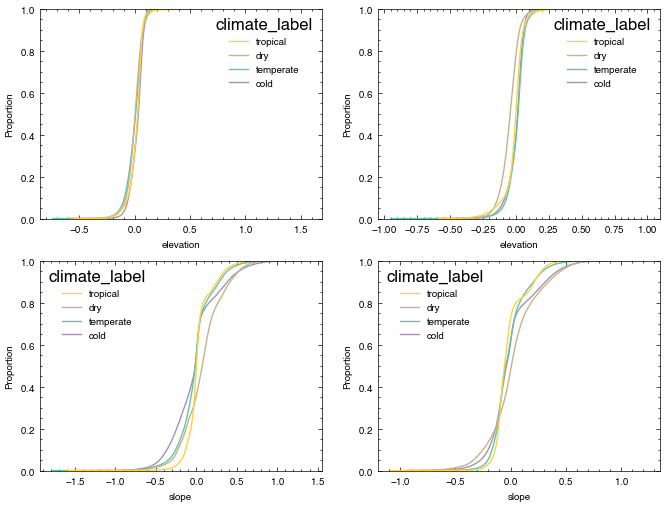

In [27]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))
sns.ecdfplot(shap_Qmin7, hue = 'climate_label', x = 'elevation', ax = axes[0,0], palette = palette)
sns.ecdfplot(shap_Qmax7, hue = 'climate_label', x = 'elevation', ax = axes[0,1], palette = palette)
sns.ecdfplot(shap_Qmin7, hue = 'climate_label', x = 'slope', ax = axes[1,0], palette = palette)
sns.ecdfplot(shap_Qmax7, hue = 'climate_label', x = 'slope', ax = axes[1,1], palette = palette)

<Axes: xlabel='slope_val', ylabel='slope'>

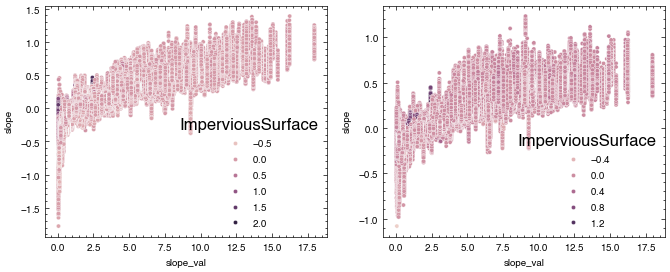

In [31]:
shap_Qmin7['elevation_val'] = df_Qmin7.elevation.copy()
shap_Qmax7['elevation_val'] = df_Qmax7.elevation.copy()
shap_Qmin7['slope_val'] = df_Qmin7.slope.copy()
shap_Qmax7['slope_val'] = df_Qmax7.slope.copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3))
sns.scatterplot(shap_Qmin7, x = 'slope_val', y = 'slope', ax = ax1, hue = 'ImperviousSurface')
sns.scatterplot(shap_Qmax7, x = 'slope_val', y = 'slope', ax = ax2, hue = 'ImperviousSurface')

<Axes: xlabel='aridity', ylabel='slope'>

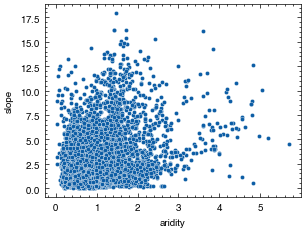

In [43]:
sns.scatterplot(tmp, x = 'aridity', y = 'slope')